In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import multiprocessing
print(f'cpu count: {multiprocessing.cpu_count()}')
import numpy as np
import numpy.typing as npt
from tqdm import tqdm
import seaborn as sns

import frame_whitening as fw
import frame_whitening.simulation as fws

cpu count: 128


In [49]:
def get_spectral_error(g, W, Cxx):
    N = W.shape[0]
    Ixx = np.eye(N)
    WGW = W @ np.diag(g) @ W.T
    M = np.linalg.inv(Ixx + WGW)
    Cyy = M @ Cxx @ M.T
    eigvals = np.linalg.eigvalsh(Cyy)
    spectral_error = np.linalg.norm(eigvals - 1)**2
    return spectral_error

def simulate_one(
    n: int, 
    eta_g: float, 
    n_batch: int, 
    frame: str,
    seed: int,
) -> npt.NDArray[np.float64]:
    """Simulate one run of whitening algorithm with random cov and given frame."""
    assert frame in ["GRASSMANN", "RANDN", "SPECTRAL", "SPECTRAL_FRAME"]
    np.random.seed(seed)
    # setup
    k = n * (n + 1) // 2
    rng = np.random.default_rng(seed=seed)
    s = np.exp((np.linspace(-3, 3, n) + rng.standard_normal((n, )))*.1) 

    Q0,_ = np.linalg.qr(rng.standard_normal((n, n)))
    # Q0 = np.eye(n)
    Cxx =  Q0@np.diag(s)@Q0.T   # COV
    M_init = np.eye(n) * 1

    # in R2 and R3, equiangular frames are known.
    if frame == "GRASSMANN":
        if n > 3:
            W, _ = fw.get_grassmannian(n, k, rng) 
        elif n == 2:
            Q, _ = np.linalg.qr(rng.standard_normal((k, k)))
            W = fw.get_mercedes_frame() @ Q.T
        else: # n == 3
            Q, _ = np.linalg.qr(rng.standard_normal((k, k)))
            W = fw.get_equiangular_3d() @ Q.T
    elif frame == "RANDN":
        W = rng.standard_normal((n, k))
    elif frame == "SPECTRAL_FRAME":
        W = np.concatenate([Q0, rng.standard_normal((n, k-n))], 1)
    else:  # spectral
        W = Q0

    W = fw.normalize_frame(W)
    g0 = fws.get_g_opt(W, M_init)

    online = False
    # online = True
    batch_size = 1
    g_last, g_all, errors, _ = fws.adapt_covariance(
        [Cxx], W, batch_size, n_batch, eta_g, g0, online, False, 1., 
        verbose=False, break_on_convergence=False, seed=seed, error_type='operator',
        )

    # errors = [get_spectral_error(g, W, Cxx) for g in g_all]

    return errors, g_last

def simulate_many(
    n: int,
    n_steps: int,
    n_repeats: int, 
    lr: float,
    frame: str,
) -> npt.NDArray[np.float64]:
    """Run all simulations in parallel."""

    with multiprocessing.Pool() as pool:
        all_errors = []
        all_g = []
        pbar = tqdm(total=n_repeats)
        for output in pool.starmap(simulate_one, [(n, lr, n_steps, frame, i) for i in range(n_repeats)]):
            errors, g_last = output
            if len(errors) != n_steps:
                errors = errors + [errors[-1]] * (n_steps - len(errors))
            all_errors.append(errors)
            all_g.append(g_last[0])
            pbar.update(1)
    all_errors = np.array(all_errors)
    return all_errors, all_g

In [98]:
n_repeats = 100
n = 2
n_steps = 20_000
# n_steps = 10_000
lr = 5E-3
# lr = 1E-4
all_errors_randn,_ = simulate_many(n, n_steps, n_repeats, lr, "RANDN")
all_errors_grassmann,_ = simulate_many(n, n_steps, n_repeats, lr, "GRASSMANN")
all_errors_spectral, g_last_spectral = simulate_many(n, n_steps, n_repeats, lr, "SPECTRAL_FRAME")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.86it/s]


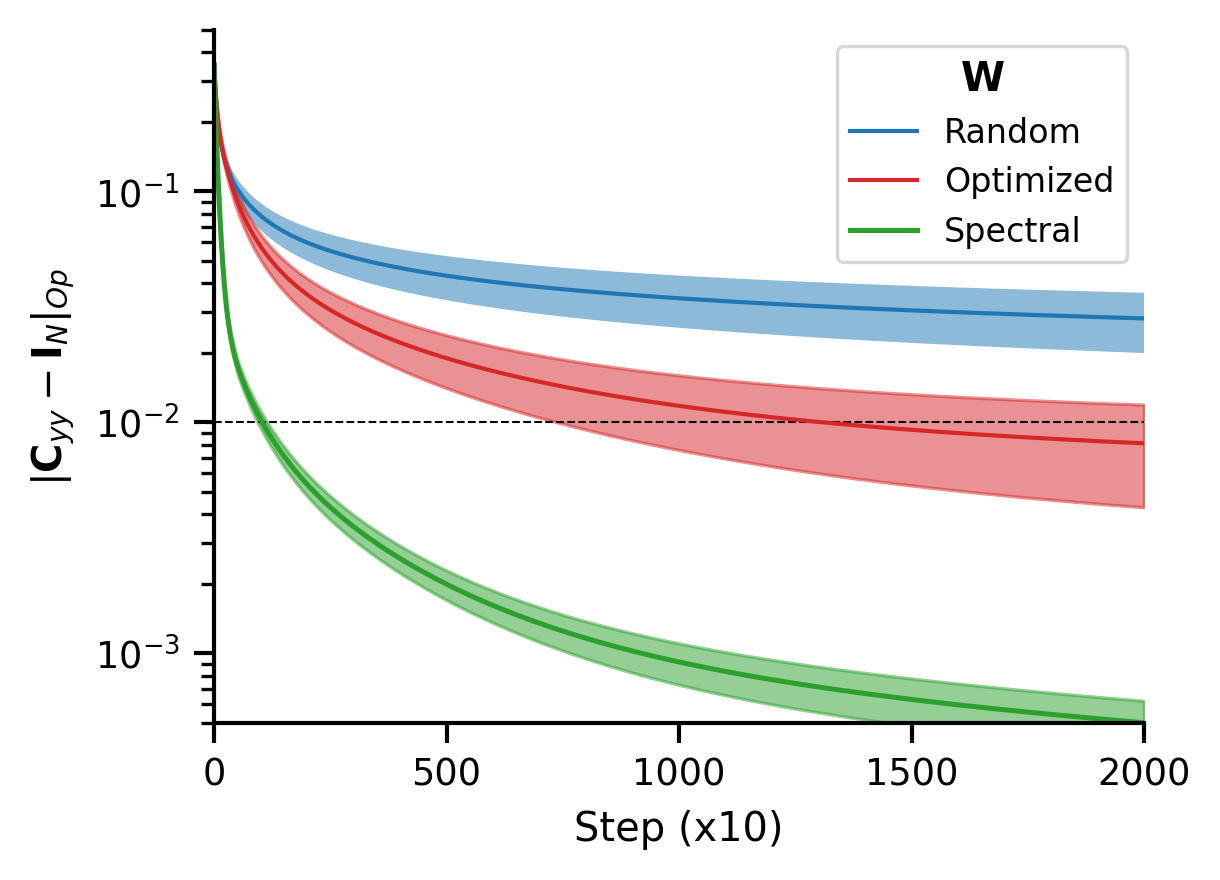

In [103]:
# fmt: off
def get_mean_sem(x):
    return np.mean(x, axis=0), np.std(x, axis=0) / np.sqrt(x.shape[0])
    
with sns.plotting_context("paper", font_scale=1):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3) ,dpi=300)

    mu_randn, sig_randn = get_mean_sem(all_errors_randn)
    mu_opt, sig_opt = get_mean_sem(all_errors_grassmann)
    mu_spectral, sig_spectral = get_mean_sem(all_errors_spectral)

    ax.hlines(1E-2, 1, n_steps, linestyles="dashed", color="k", linewidth=0.5)
    ax.plot(range(1, len(mu_randn)+1), mu_randn, color="C0", label="Random", linewidth=1)
    ax.fill_between(range(1, len(mu_randn)+1), mu_randn - sig_randn, mu_randn + sig_randn, alpha=0.5)

    ax.plot(range(1, len(mu_opt)+1), mu_opt, color="C3", label="Optimized", linewidth=1)
    ax.fill_between(range(1, len(mu_opt)+1), mu_opt - sig_opt, mu_opt + sig_opt, color="C3", alpha=0.5)

    ax.plot(range(1, len(mu_spectral)+1), mu_spectral, color="C2", label="Spectral")
    ax.fill_between(range(1, len(mu_spectral)+1), mu_spectral - sig_spectral, mu_spectral + sig_spectral, color="C2", alpha=0.5)
    # ax.plot(range(1, len(mu_spectral)+1), mu_spectral, color="C2", label="Spectral", linewidth=1)

    ax.set(yscale="log", 
    xscale="linear", 
    # ylabel=r"$\frac{1}{N^2}\|{\bf C}_{yy} - {\bf I}_N\|_F^2$", 
    ylabel=r"$\|{\bf C}_{yy} - {\bf I}_N\|_{Op}$", 
    xlabel="Step (x10)", 
    # xticks=(1, n_steps), 
    xticks=np.arange(0, n_steps+1, (n_steps+1)//4),
    xticklabels=np.arange(0, (n_steps)//10+1, (n_steps+1)//40),
    xlim=(0, n_steps),
    ylim=(5E-4, 5E-1),
    # ylim=(0., 0.03)
    )

    ax.legend(title=r"${\bf W}$", loc="upper right", fontsize=8)

    sns.despine()
# fmt: on

## context switching

In [9]:
N = 6
Kn = N * (N + 1) // 2

rng = np.random.default_rng(0)
# generate two contexts: two covariance matrices with eigenvectors V1 and V2

# V1, _ = np.linalg.qr(rng.standard_normal((N, N)))
V1 = np.eye(N)
V2, _ = np.linalg.qr(rng.standard_normal((N, N)))
V3, _ = np.linalg.qr(rng.standard_normal((N, N)))
# s = np.exp(rng.uniform(0, 4, N))
s = np.exp((np.linspace(-3, 3, N) + rng.standard_normal((N, )))*.1) 

C1 = V1 @ np.diag(s) @ V1.T
C2 = V2 @ np.diag(s) @ V2.T
C3 = V3 @ np.diag(s) @ V3.T
# C2 = C1

W = np.concatenate([V1, V2, rng.standard_normal((N, Kn-(2*N)))], 1)
# W = np.concatenate([V1, rng.standard_normal((N, Kn-N))], 1)
W = fw.normalize_frame(W)
# W = V1

eta_g = 1E-3

n_batch = 15_000
online = False
batch_size = 1
save_every = 10

g0 = np.zeros((Kn,))
# g0 = np.ones(Kn) * 5
g_last, g_all, errors, _ = fws.adapt_covariance(
    [C1, C2, C1, C2], W, batch_size, n_batch, eta_g, g0, 
    online, False, 1., verbose=True, break_on_convergence=False, save_every=save_every,
    error_type="operator",
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:04<00:00, 14296.67it/s]


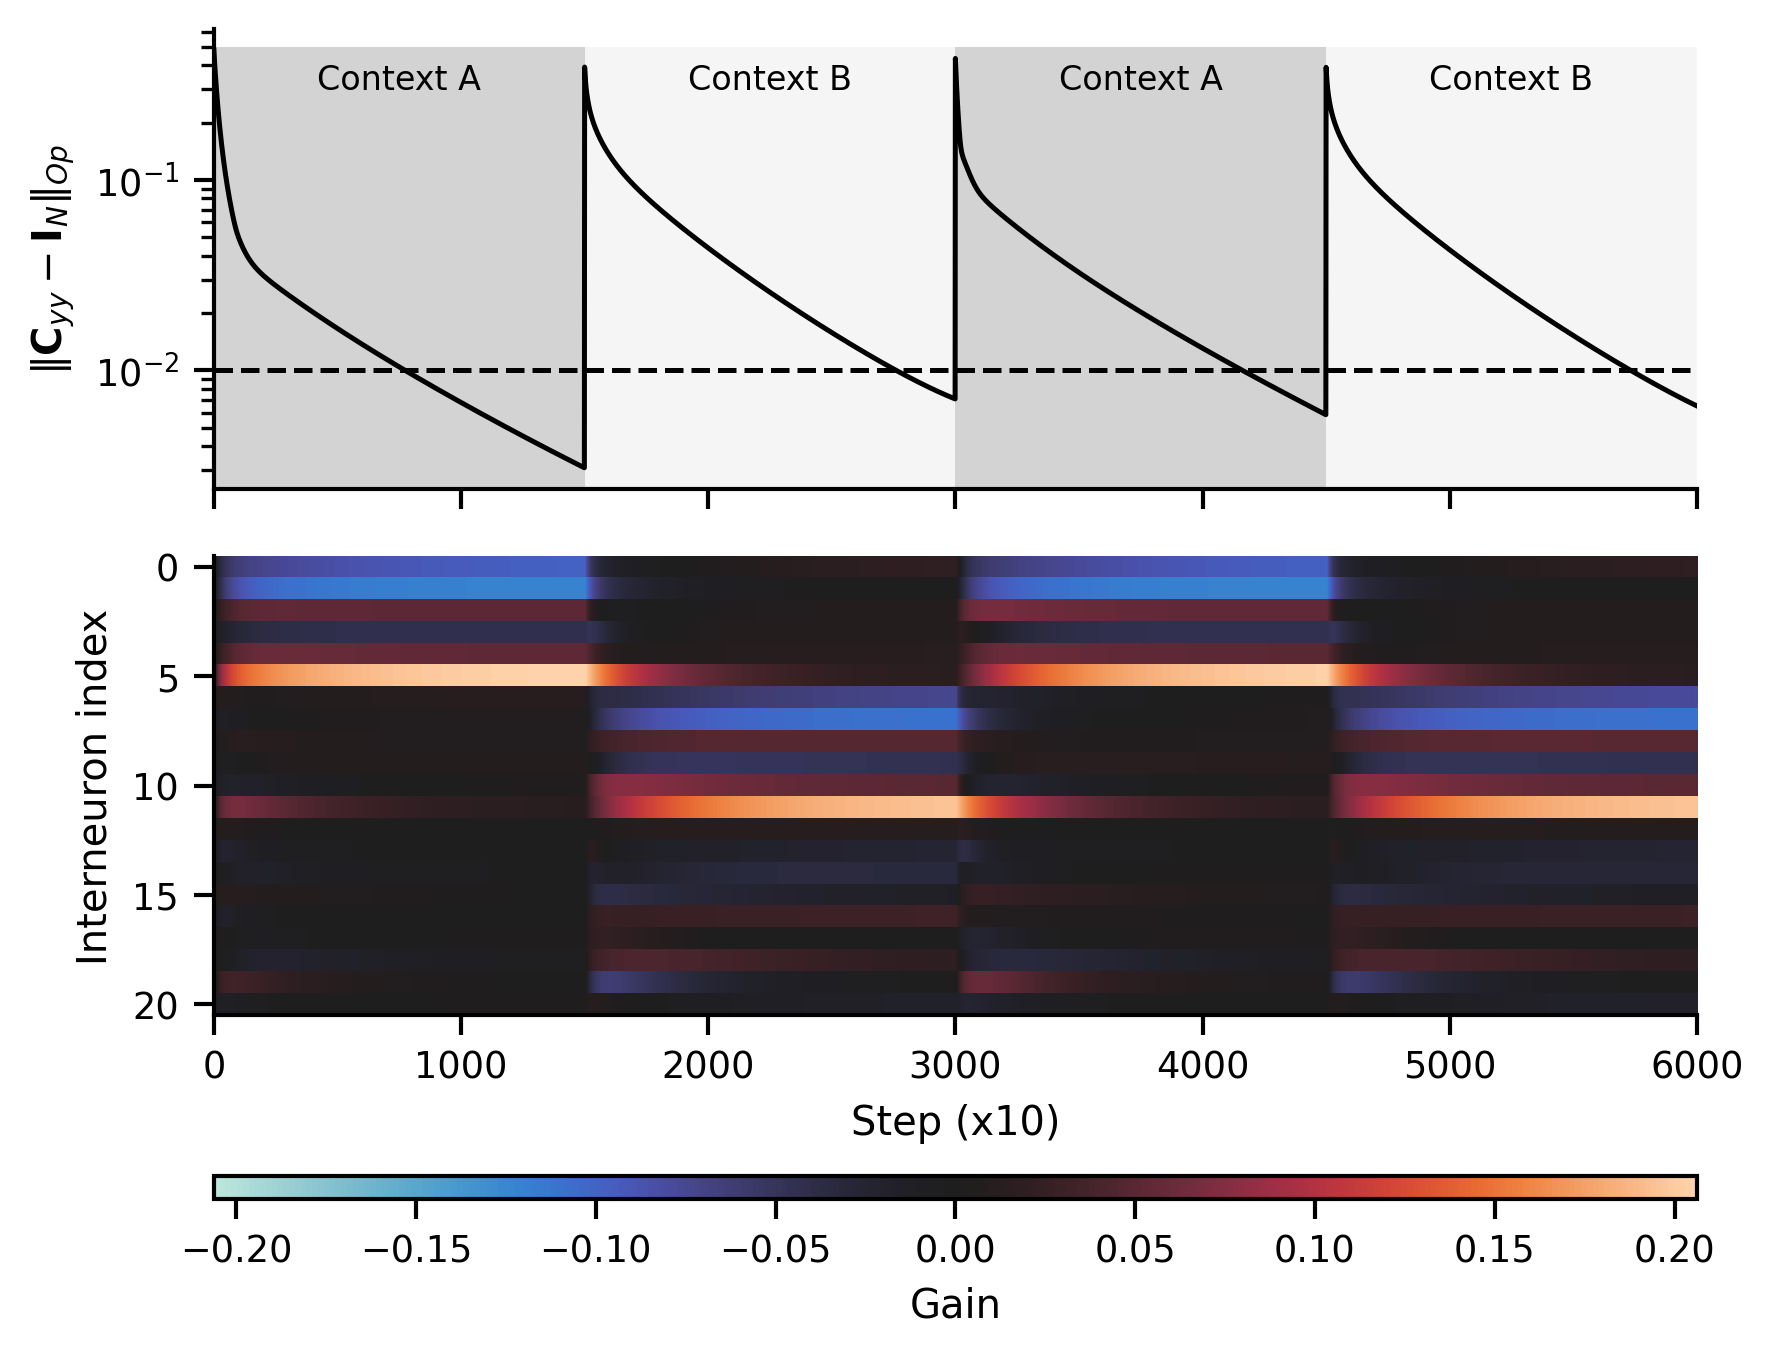

In [22]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

g_all_plot = g_all[0:]
cmap = sns.color_palette('icefire', as_cmap=True)
vmax = np.max(np.abs(g_all_plot))
vmin = -vmax

with sns.plotting_context('paper'):
    fig, ax = plt.subplots(2, 1, sharex='all', figsize=(6, 4), dpi=300)
    ax[0].plot(errors, color='k')
    ax[0].hlines(1E-2, 0, len(errors), color='k', linestyle='--')
    im = ax[1].imshow(g_all_plot.T, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax, interpolation='none')

    # ax[0].set(yscale='log', ylabel=r'$\frac{1}{N^2}\Vert{\bf C}_{yy} - {\bf I}_N\Vert_2$')
    ax[0].set(yscale='log', ylabel=r'$\Vert{\bf C}_{yy} - {\bf I}_N\Vert_{Op}$')
    ax[1].set(xlabel='Step (x10)', ylabel='Interneuron index')

    sns.despine()
    fig.tight_layout()

    # plot filled rectangle from y = 1E-6 to 1E-2 and from x = to 1000 on ax[0]
    from matplotlib.patches import Rectangle
    recta1 = Rectangle((0, 1E-6), 1500, 5E-1, linewidth=1, edgecolor='none', facecolor='lightgrey', zorder=-1)
    recta2 = Rectangle((3000, 1E-6), 1500, 5E-1, linewidth=1, edgecolor='none', facecolor='lightgrey', zorder=-1)
    ax[0].add_patch(recta1)
    ax[0].add_patch(recta2)
    # shift rightward by 1500
    rectb1 = Rectangle((1500, 1E-6), 1500, 5E-1, linewidth=1, edgecolor='none', facecolor='whitesmoke', zorder=-1)
    rectb2 = Rectangle((4500, 1E-6), 1500, 5E-1, linewidth=1, edgecolor='none', facecolor='whitesmoke', zorder=-1)
    ax[0].add_patch(rectb1)
    ax[0].add_patch(rectb2)

    # place text saying 'Context 1' and 'Context 2' on ax[0]
    ax[0].text(750, 3E-1, 'Context A', fontsize=8, ha='center')
    ax[0].text(1500+750, 3E-1, 'Context B', fontsize=8, ha='center')
    ax[0].text(1500*2 + 750, 3E-1, 'Context A', fontsize=8, ha='center')
    ax[0].text(1500*3 + 750, 3E-1, 'Context B', fontsize=8, ha='center')


    axins = inset_axes(ax[1],
                        width="100%",  
                        height="5%",
                        loc='lower center',
                        borderpad=-5
                    )
    fig.colorbar(im, cax=axins, orientation="horizontal", label="Gain")
